# SQUID

## initial imports

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks
import scienceplots
plt.style.use('science')


In [86]:
# normalize
def normalize(arr, t_min, t_max):
    arr = arr.to_numpy()
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    arr = arr.to_numpy()
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    arr = arr.to_numpy()
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Diode Calibration

### Load data

In [87]:
room_temp = pd.read_csv('SQUID/data/V-I/roomtemp.csv')
liquid_nitrogen = pd.read_csv('SQUID/data/V-I/crittemp.csv')
room_temp

,0_x,0_y
0,0.985322,33.925200
1,1.749933,102.407787
2,4.553510,172.417867
3,6.337605,239.627543
4,8.121699,307.855548
...,...,...
495,60.625049,1062.182331
496,61.134790,1062.182331
497,63.938367,1062.182331
498,65.467591,1062.182331


### analysis

1.6325167650794552
R_N = 3.265+/-0.010 Ohm


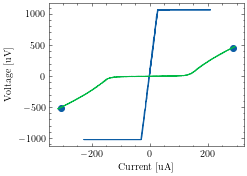

In [88]:
plt.plot(room_temp['0_x'], room_temp['0_y'], label='room temp')
plt.plot(liquid_nitrogen['0_x'], liquid_nitrogen['0_y'], label='liquid nitrogen')
plt.xlabel('Current [uA]')
plt.ylabel('Voltage [uV]')
dx = [liquid_nitrogen['0_x'][350],liquid_nitrogen['0_x'][120]]
dy = [liquid_nitrogen['0_y'][350],liquid_nitrogen['0_y'][120]]
plt.scatter(dx,dy)
normal_slope =(dy[1]- dy[0]) / (dx[1]- dx[0])
print(normal_slope)
R_N = un.ufloat(normal_slope*2, 0.01)
print(f"R_N = {R_N} Ohm")

242.3+/-2.6
5.623+/-0.028


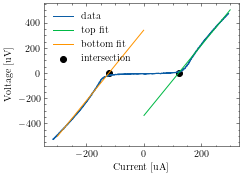

In [89]:
mi,ma = 60, 165
x,y = liquid_nitrogen['0_x'], liquid_nitrogen['0_y']
plt.plot(x, y ,label='data')

xl = np.linspace(-300,300,500)
half = int(len(xl)/2)

# plt.plot(x[mi:ma], y[mi:ma] ,label='top data')
c, cov = curve_fit(lambda x, a, b: a*x + b, x[mi:ma], y[mi:ma])
perr = np.sqrt(np.diag(cov))
x0= - un.ufloat(c[1],perr[1])/un.ufloat(c[0],perr[0]) 
slope_top = un.ufloat(c[0],perr[0]) 

plt.plot(xl[half:], c[0]*xl[half:] + c[1], label='top fit',lw=1)

mi,ma = 280, 410
# plt.plot(x[mi:ma], y[mi:ma] ,label='bottom data')
c, cov = curve_fit(lambda x, a, b: a*x + b, x[mi:ma], y[mi:ma])
perr = np.sqrt(np.diag(cov))

plt.plot(xl[:half], c[0]*xl[:half] + c[1], label='bottom fit',lw=1)
width = x0 + un.ufloat(c[1],perr[1])/un.ufloat(c[0],perr[0])
print(width)

plt.scatter([x0.n,-c[1]/c[0]],[0,0],c='k',label='intersection')

res_n = (slope_top + un.ufloat(c[0],perr[0]) )
print(res_n)
plt.legend()
plt.xlabel('Current [uA]')
plt.ylabel('Voltage [uV]')

plt.savefig('SQUID/output/2-critical-current.png', dpi=300)

In [90]:
print(f"width= {width*1e-3} mA")
critical_current = width /4 * 1e-6
print(f"I_crit= {critical_current*1e6} uA")
critical_voltage1 = critical_current * R_N
print(f"U_crit1= {critical_voltage1*1e3} mV")
critical_voltage2 = critical_current * res_n
print(f"U_crit2= {critical_voltage2*1e3} mV")


width= 0.2423+/-0.0026 mA
I_crit= 60.6+/-0.6 uA
U_crit1= 0.1978+/-0.0022 mV
U_crit2= 0.341+/-0.004 mV


(-373.19587628865975+/-1.5264446888479353,
 444.74793814432985+/-1.2277405249506017)

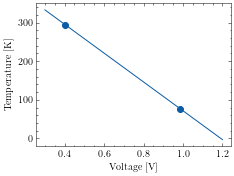

In [91]:
calibr_temp = [21.2+273.15, 77.15]
calibr_volts = [403*1e-3, 985*1e-3]

calibr_temp = unp.uarray(calibr_temp,[0.4,0.05])
calibr_volts = unp.uarray(calibr_volts,1.5e-3)

voltrange = np.linspace(300e-3, 1200e-3, 1000)

plt.scatter(unp.nominal_values(calibr_volts), unp.nominal_values(calibr_temp), label='calibration points')

m = (calibr_temp[1]-calibr_temp[0])/(calibr_volts[1]-calibr_volts[0])
b = calibr_temp[0] - m*calibr_volts[0]

plt.plot(voltrange, unp.nominal_values(m*voltrange + b), label='fit')

def temp(volt):
    return m*volt + b

plt.xlabel('Voltage [V]')
plt.ylabel('Temperature [K]')
plt.savefig('SQUID/output/2-diode-calibration.png', dpi=300)

m, b

## 2 Temperature dependency

### Load data

In [92]:
t1 = pd.read_csv('SQUID/data/tempdep_part1.csv')
t2 = pd.read_csv('SQUID/data/tempdep_part2.csv')
t3 = pd.read_csv('SQUID/data/tempdep_part3.csv')
t1

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y
0,122.303741,6.430333,120.774517,5.921169,120.774517,9.739900,120.009906,13.304050,121.539129,31.379379,120.519647,123.538102,122.558612,262.539933,121.539129,233.262990
1,124.597577,6.430333,123.068353,11.521975,122.048871,14.576960,122.303741,20.177767,123.323224,34.434365,122.813483,132.193894,124.852448,268.140739,122.558612,240.391289
2,126.891413,11.012811,125.617059,14.576960,125.617059,14.322378,124.597577,23.232752,125.617059,43.853903,125.617059,138.303864,127.146283,273.486963,126.126801,244.210021
3,129.949860,12.794886,128.420636,14.322378,127.146283,27.560648,127.656024,28.324394,128.675507,52.764276,128.675507,145.177581,129.694990,280.106098,127.910895,251.338320
4,131.988825,18.141110,130.714472,17.631946,130.714472,26.542319,129.949860,37.998514,131.224213,59.128829,130.714472,151.032970,132.498566,284.943158,130.714472,255.411634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,204.881825,238.609215,203.352601,240.645872,203.607472,252.611231,203.097731,259.484947,204.626955,278.833188,203.862343,332.295430,204.881825,450.676110,203.607472,406.633405
496,207.430532,246.755842,206.920790,247.265006,205.391567,258.212037,204.881825,267.122411,205.901308,284.179412,204.881825,339.423729,207.430532,456.531498,206.156178,412.488794
497,210.488979,253.884141,207.685402,255.157052,208.195143,266.613246,208.704885,273.232381,209.214626,292.071457,208.959755,344.515371,210.743850,462.641469,208.195143,416.816690
498,212.782815,261.521604,210.743850,261.776186,210.234108,273.996128,210.998720,280.615262,211.763332,297.926846,210.998720,350.370760,212.527944,468.242275,210.743850,423.944989


Text(0, 0.5, 'Temperature [K]')

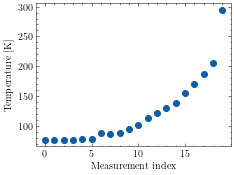

In [93]:
voltages = [986, 985.8, 986.6, 985.7, 985.2, 984.8, 958, 959.5, 957, 940, 920, 890, 867, 843, 820, 777, 736,690,642,0]
temps = temp(unp.uarray(voltages, 1.2)*1e-3)
temps[-1]= calibr_temp[0]
plt.scatter(range(len(temps)), unp.nominal_values(temps), label='measured temperatures')
plt.xlabel('Measurement index')
plt.ylabel('Temperature [K]')


### analysis

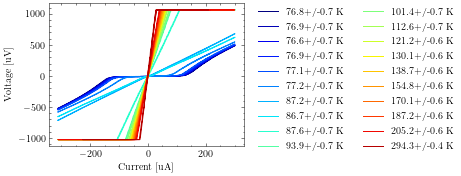

In [94]:
plots = 20

# part 1
for i in range(8):
    plt.plot(t1[f'{i}_x'], t1[f'{i}_y'], label=f'{temps[i]} K', c= mapcolors(plots)[i])

# part 2
for i in range(8):
    plt.plot(t2[f'{i}_x'], t2[f'{i}_y'], label=f'{temps[i+8]} K', c= mapcolors(plots)[i+8])

for i in range(3):
    plt.plot(t3[f'{i}_x'], t3[f'{i}_y'], label=f'{temps[i+16]} K', c= mapcolors(plots)[i+16])

plt.plot(room_temp['0_x'], room_temp['0_y'], label=f'{calibr_temp[0] } K', c= mapcolors(plots)[-1])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)

i=7
# plt.plot(t1[f'{i}_x'], t1[f'{i}_y'], label=f'{temps[i]} K', c= 'k')

plt.xlabel('Current [uA]')
plt.ylabel('Voltage [uV]')

plt.savefig('SQUID/output/2-temperature-dependency.png', dpi=300)


In [95]:
def linfit(x, a, b):
    return a*x + b

# create empty unumpy arrays
resistances = unp.uarray(np.zeros(20), np.zeros(20))

87.6+/-0.7 K: 2.834+/-0.018 Ohm
93.9+/-0.7 K: 2.800+/-0.018 Ohm
101.4+/-0.7 K: 2.721+/-0.017 Ohm
112.6+/-0.7 K: 2.680+/-0.017 Ohm
121.2+/-0.6 K: 2.576+/-0.015 Ohm
130.1+/-0.6 K: 2.241+/-0.008 Ohm
138.7+/-0.6 K: 2.321+/-0.006 Ohm
154.8+/-0.6 K: 2.135+/-0.006 Ohm


Text(0, 0.5, 'Voltage [uV]')

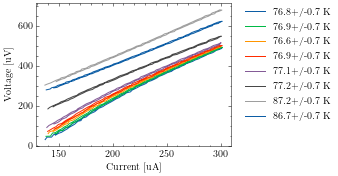

In [96]:
#part 1 alt
a,b = 10,130
for i in range(8):
    x,y = t1[f'{i}_x'][a:b], t1[f'{i}_y'][a:b]
    plt.plot(x, y, label=f'{temps[i]} K')
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    # resistances[i] = resistance
    print(f'{temps[i+8]} K: {resistance} Ohm')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.xlim(-10, 10)
# plt.ylim(-50, 50)

plt.xlabel('Current [uA]')
plt.ylabel('Voltage [uV]')

76.8+/-0.7 K: 0.028+/-0.004 Ohm
76.9+/-0.7 K: 0.037+/-0.004 Ohm
76.6+/-0.7 K: 0.0421+/-0.0033 Ohm
76.9+/-0.7 K: 0.039+/-0.004 Ohm
77.1+/-0.7 K: 0.051+/-0.006 Ohm
77.2+/-0.7 K: 0.122+/-0.006 Ohm


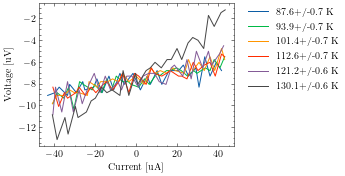

In [97]:
# part 1 neue

a,b = 165,198
for i in range(6):
    x,y = t1[f'{i}_x'][a:b] , t1[f'{i}_y'][a:b]
    plt.plot(x, y, label=f'{temps[i+8]} K')
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    # resistances[i+8] = resistance
    print(f'{temps[i]} K: {resistance} Ohm')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Current [uA]')
plt.ylabel('Voltage [uV]')

plt.savefig('SQUID/output/2-low-temp-resistance.png', dpi=300)


14
87.2+/-0.7 K: 2.039+/-0.014 Ohm
86.7+/-0.7 K: 1.60+/-0.04 Ohm
87.6+/-0.7 K: 9.176+/-0.035 Ohm
93.9+/-0.7 K: 13.38+/-0.04 Ohm
101.4+/-0.7 K: 14.25+/-0.04 Ohm
112.6+/-0.7 K: 15.72+/-0.05 Ohm
121.2+/-0.6 K: 17.00+/-0.05 Ohm
130.1+/-0.6 K: 17.82+/-0.06 Ohm
138.7+/-0.6 K: 18.83+/-0.06 Ohm
154.8+/-0.6 K: 20.35+/-0.07 Ohm
170.1+/-0.6 K: 22.25+/-0.07 Ohm
187.2+/-0.6 K: 24.08+/-0.07 Ohm
205.2+/-0.6 K: 25.79+/-0.13 Ohm
294.3+/-0.4 K: 36.93+/-0.21 Ohm
3.20+/-0.08


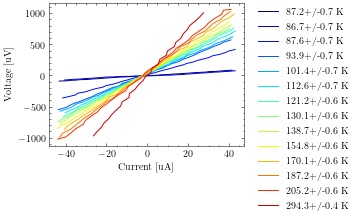

In [98]:
a,b = 165,198
# part 1 continued

colors = mapcolors(len(temps)-6)
print(len(colors))
for i in range(6,8):
    x,y = t1[f'{i}_x'][a:b] , t1[f'{i}_y'][a:b]
    plt.plot(x, y, label=f'{temps[i]} K', c= colors[i-6])
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    resistances[i] = resistance
    print(f'{temps[i]} K: {resistance} Ohm')


# part 2 + 3

for i in range(8):
    x,y = t2[f'{i}_x'][a:b] , t2[f'{i}_y'][a:b]
    plt.plot(x, y, label=f'{temps[i+8]} K', c= colors[i+2])
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    resistances[i+8] = resistance
    print(f'{temps[i+8]} K: {resistance} Ohm')

for i in range(3):
    x,y = t3[f'{i}_x'][a:b] , t3[f'{i}_y'][a:b]
    plt.plot(x, y, label=f'{temps[i+16]} K', c= colors[i+10])
    c, cov = curve_fit(linfit, x, y)
    resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
    resistances[i+16] = resistance
    print(f'{temps[i+16]} K: {resistance} Ohm')

a,b = 448,478
x,y = room_temp['0_x'][a:b] , room_temp['0_y'][a:b]
plt.plot(x, y, label=f'{temps[-1]} K', c= colors[-1])
c, cov = curve_fit(linfit, x, y)
resistance = un.ufloat(c[0], np.sqrt(cov[0,0]))
resistances[-1] = resistance
print(f'{calibr_temp[0]} K: {resistance} Ohm')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Current [uA]')
plt.ylabel('Voltage [uV]')

normal_resistances = resistances[7]*2
print(normal_resistances)

plt.savefig('SQUID/output/2-higher-temp-resistance.png', dpi=300)


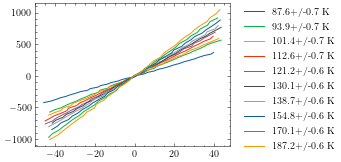

In [99]:
# part 2 + 3 second data interval
a,b = 398,432
for i in range(8):
    plt.plot(t2[f'{i}_x'][a:b], t2[f'{i}_y'][a:b], label=f'{temps[i+8]} K')

for i in range(2):
    plt.plot(t3[f'{i}_x'][a:b], t3[f'{i}_y'][a:b], label=f'{temps[i+16]} K')



plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


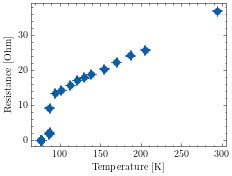

In [100]:
plt.errorbar(unp.nominal_values(temps), unp.nominal_values(resistances), xerr=unp.std_devs(temps), yerr=unp.std_devs(resistances), fmt='o',capsize=5, label='data')

plt.xlabel('Temperature [K]')
plt.ylabel('Resistance [Ohm]')

plt.savefig('SQUID/output/2-resistance-temperature.png', dpi=300)


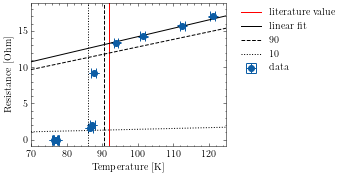

In [101]:
lim = 14
plt.errorbar(unp.nominal_values(temps[:lim]), unp.nominal_values(resistances[:lim]), xerr=unp.std_devs(temps)[:lim], yerr=unp.std_devs(resistances)[:lim], fmt='o',capsize=5, label='data')

plt.xlabel('Temperature [K]')
plt.ylabel('Resistance [Ohm]')

plt.xlim(70,125)
plt.axvline(x=92, c='r', label='literature value')

xl = np.linspace(70,125)

x = unp.nominal_values(temps[9:])
y = unp.nominal_values(resistances[9:])
c, cov = curve_fit(linfit,x,y, )
param = unp.uarray(c, np.sqrt(np.diag(cov)))

plt.plot(xl,linfit(xl,*c),label=r"linear fit", c='k', lw=1)

plt.plot(xl,linfit(xl,*c)*.9,label=r"90%", c='k',ls='--',lw=1)
plt.axvline(x=90.5, c='k',ls='--',lw=1)

plt.plot(xl,linfit(xl,*c)*.1,label=r"10%", c='k',ls=':',lw=1)
plt.axvline(x=86, c='k',ls=':',lw=1)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
# print(f"{temps[7]-1} K")
# plt.grid()

plt.savefig('SQUID/output/2-resistance-temperature-zoom.png', dpi=300)


## 3 Flux dependency

### load data

In [102]:
flux1 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.07.29_Trace.csv',skiprows=1)
flux2 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.08.24_Trace.csv',skiprows=1)
flux3 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.44_Trace.csv',skiprows=1)
flux4 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.47_Trace.csv',skiprows=1)
flux5 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.50_Trace.csv',skiprows=1)
knee = pd.read_csv('SQUID/data/V-I/knee.csv')
increment= 0.0000002 * 1e6 # step size in us 
flux4, knee

(      Sequence   VOLT   VOLT.1  0.01652000  0.0000002000000
 0            0   15.2   0.0448         NaN              NaN
 1            1   15.2   0.0464         NaN              NaN
 2            2   14.8   0.0456         NaN              NaN
 3            3   15.2   0.0488         NaN              NaN
 4            4   14.8   0.0488         NaN              NaN
 ...        ...    ...      ...         ...              ...
 1195      1195   15.2   0.0144         NaN              NaN
 1196      1196   14.8   0.0128         NaN              NaN
 1197      1197   15.2   0.0080         NaN              NaN
 1198      1198   15.2   0.0064         NaN              NaN
 1199      1199   14.8   0.0040         NaN              NaN
 
 [1200 rows x 5 columns],
             0_x        0_y         1_x        1_y         2_x        2_y  \
 0    120.009906   9.230736  120.519647  13.049468  120.264776  11.012811   
 1    121.029388   6.939497  119.755035   3.884512  120.009906   1.847855   
 2    120

### analysis

In [103]:
def sinfit(x, Delta_U, U_0, phi_s, phi_0):
    return Delta_U*np.sin(2*np.pi*(x-phi_s)/phi_0) + U_0

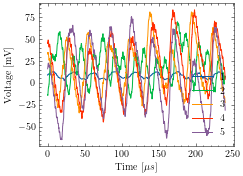

In [104]:
plt.plot(flux1['Sequence']*increment, flux1[' VOLT.1']*1e3, label='1')
plt.plot(flux2['Sequence']*increment, flux2[' VOLT.1']*1e3, label='2')
plt.plot(flux3['Sequence']*increment, flux3[' VOLT.1']*1e3, label='3')
plt.plot(flux4['Sequence']*increment, flux4[' VOLT.1']*1e3, label='4')
plt.plot(flux5['Sequence']*increment, flux5[' VOLT.1']*1e3, label='5')

plt.xlabel('Time [$\mu s$]')
plt.ylabel('Voltage [mV]')

plt.legend()

[38.98569971  5.6712316   1.1731034   1.41592513] [0.44661492 0.32376526 0.0039604  0.00227612]
\Delta U = 0.0780+/-0.0009 mV
U_0 = (5.67+/-0.32)e+03 uV
\phi_s = 11.73+/-0.04 us
\phi_0 = 14.159+/-0.023 us


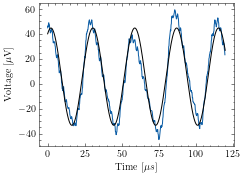

In [105]:
cut = 600

x = np.linspace(0, 6, 1000)
# plt.plot(flux1['Sequence'], flux1[' VOLT.1'], label='1')
# plt.plot(flux2['Sequence'], flux2[' VOLT.1'], label='2')
# plt.plot(flux3['Sequence']*1e-3, flux3[' VOLT.1']*1e3, label='3')
plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT.1'][:cut]*1e3, label='data')
# plt.plot(flux5['Sequence']*1e-3, flux5[' VOLT.1']*1e3, label='5')

c, cov = curve_fit(sinfit, flux4['Sequence'][:cut]*1e-2, flux4[' VOLT.1'][:cut]*1e3)
perr=np.sqrt(np.diag(cov))
plt.plot(x*increment*1e2, sinfit(x, *c) , label='fit',c='k')
print(c, perr)
Delta_U = 2*un.ufloat(c[0],perr[0])*1e-6 # in V
print(f"\Delta U = {Delta_U*1e3} mV")
print(f"U_0 = {un.ufloat(c[1],perr[1])*1e3} uV")
print(f"\phi_s = {un.ufloat(c[2],perr[2])*increment/2e-2} us")
phi_0 = un.ufloat(c[3],perr[3])*increment/2e-2 * 1e-6 # in s
print(f"\phi_0 = {phi_0*1e6} us")

plt.xlabel('Time [$\mu s$]')
plt.ylabel('Voltage [$\mu$V]')

# plt.legend()

plt.savefig('SQUID/output/3-flux-oscillation.png', dpi=300)


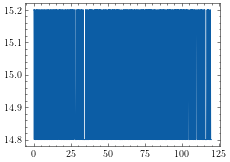

In [106]:
# plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT.1'][:cut], label='4')
cut = 600
plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT'][:cut], label='4')
# plt.plot(flux4[' VOLT'][:cut]*increment, flux4[' VOLT.1'][:cut], label='4')

/home/emil/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 50.0)

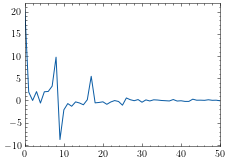

In [107]:
#fourier transform of the signal from flux4
plt.plot(np.fft.fft(flux4[' VOLT.1']))
plt.xlim(0,50)

# find peaks 

(0.0, 50.0)

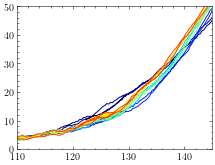

In [108]:
w= 15
plt.plot(knee['0_x'].rolling(window=w).mean(), knee['0_y'].rolling(window=w).mean(), label='1',c=mapcolors(6)[0])
plt.plot(knee['1_x'].rolling(window=w).mean(), knee['1_y'].rolling(window=w).mean(), label='2',c=mapcolors(6)[1])
plt.plot(knee['2_x'].rolling(window=w).mean(), knee['2_y'].rolling(window=w).mean(), label='3',c=mapcolors(6)[2])
plt.plot(knee['3_x'].rolling(window=w).mean(), knee['3_y'].rolling(window=w).mean(), label='4',c=mapcolors(6)[3])
plt.plot(knee['4_x'].rolling(window=w).mean(), knee['4_y'].rolling(window=w).mean(), label='5',c=mapcolors(6)[4])
plt.plot(knee['5_x'].rolling(window=w).mean(), knee['5_y'].rolling(window=w).mean(), label='6',c=mapcolors(6)[5])
plt.xlim(110,145)
plt.ylim(0,50)

#### $\beta_L$ calculation

In [109]:
induction = 73e-12
phi_0 = con.h/(2*con.elementary_charge)
beta_L1 = 2*critical_current*induction/phi_0
print(f"beta_L1 = {beta_L1}")

beta_L2_1 = 4* critical_current*normal_resistances/(np.pi * Delta_U) -1
print(f"beta_L2 v1 = {beta_L2_1}")

# beta_L2_2 = 4* critical_current*res_n/(np.pi * Delta_U) -1
# print(f"beta_L2 v2 = {beta_L2_2}")

# beta_L3_1 = 4* critical_current*normal_resistances/(np.pi * Delta_U*1e-3) *(1-3.57*unp.sqrt(con.k*induction*calibr_temp[1])/phi_0) -1
# print(f"beta_L3 v1 = {beta_L3_1}")

# beta_L3_2 = 4* critical_current*res_n/(np.pi * Delta_U) *(1-3.57*unp.sqrt(con.k*induction*calibr_temp[1])/phi_0) -1
# print(f"beta_L3 v2 = {beta_L3_2}")

beta_L1 = 4.28+/-0.05
beta_L2 v1 = 2.16+/-0.09


## 4 Flux quantum

### load data

In [110]:
steps=pd.read_csv('SQUID/data/mw-ind-steps.csv')
steps

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y
0,122.303741,152.560462,121.539129,182.091987,120.009906,217.733482,121.539129,100.625713,121.794000,9.994482
1,124.087836,157.906687,124.852448,188.201957,123.578094,223.588870,123.832965,109.026922,124.852448,4.648258
2,127.146283,160.961672,127.146283,188.201957,125.362189,228.171348,126.891413,111.572743,127.401154,13.813214
3,129.440119,164.271239,130.204731,195.584839,127.910895,233.772155,129.440119,119.210206,129.185248,10.758229
4,131.988825,167.835389,132.243696,198.385242,131.479084,238.100050,131.988825,124.301849,132.753437,19.668602
...,...,...,...,...,...,...,...,...,...,...
495,204.626955,271.195724,205.136696,302.509324,203.607472,335.604998,205.136696,258.212037,204.372084,237.081722
496,207.430532,270.941142,206.411049,308.619294,206.156178,335.859580,207.175661,260.757858,207.685402,245.482932
497,209.214626,276.287367,209.724367,312.692608,207.940273,340.951222,209.724367,265.594918,209.214626,252.865813
498,212.782815,276.796531,212.273074,318.038832,211.253591,342.733297,213.037685,270.177396,212.527944,258.721201


### analysis

steps_lit = 9.09846893323249e-05


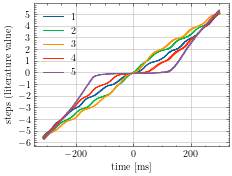

In [111]:
steps_lit = con.h/(2*con.elementary_charge) * 44e9
print(f"steps_lit = {steps_lit}")
plt.plot(steps['0_x'], steps['0_y']*1e-6/steps_lit, label='1')
plt.plot(steps['1_x'], steps['1_y']*1e-6/steps_lit, label='2')
plt.plot(steps['2_x'], steps['2_y']*1e-6/steps_lit, label='3')
plt.plot(steps['3_x'], steps['3_y']*1e-6/steps_lit, label='4')
plt.plot(steps['4_x'], steps['4_y']*1e-6/steps_lit, label='5')

plt.legend()
plt.xlabel('time [ms]')
plt.ylabel('steps (literature value)')

plt.yticks(np.arange(-6, 6, step=1))

plt.grid()



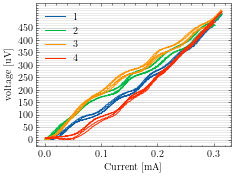

In [115]:
plt.plot(np.abs(steps['0_x'])*1e-3, np.abs(steps['0_y']), label='1',lw=1)
plt.plot(np.abs(steps['1_x'])*1e-3, np.abs(steps['1_y']), label='2',lw=1)
plt.plot(np.abs(steps['2_x'])*1e-3, np.abs(steps['2_y']), label='3',lw=1)
plt.plot(np.abs(steps['3_x'])*1e-3, np.abs(steps['3_y']), label='4',lw=1)
# plt.plot(np.abs(steps['4_x'])*1e-3, np.abs(steps['4_y']), label='5',lw=1)

plt.legend()
plt.xlabel('Current [mA]')
plt.ylabel('voltage [uV]')

# print(steps_lit*1e9)
plt.yticks(np.arange(0,500,step=50))

plt.grid(which='major', axis='y')
plt.grid(which='minor', alpha=0.5, axis='y')
plt.minorticks_on()

plt.savefig('SQUID/output/4-shapiro-steps.png')

# plt.yticks(np.arange(0,500,step=1e6*steps_lit))

# plt.savefig('SQUID/output/shapiro-steps-theo.pdf')


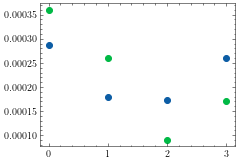

In [113]:
v1 = unp.uarray([0.000288,	0.00018,	0.000173,	0.00026],0.00001)
v2 = unp.uarray([0.00036,	0.00026,	0.000091,	0.00017],0.00001)
shapiro_steps = np.abs(v1-v2)
plt.scatter(range(len(v1)), unp.nominal_values(v1), label='1')
plt.scatter(range(len(v2)), unp.nominal_values(v2), label='2')

# plt.scatter(range(len(shapiro_steps)), unp.nominal_values(shapiro_steps), label='1')

In [114]:
n_step,u_step = 0,0

for s in shapiro_steps:
    n_step += unp.nominal_values(s)
    u_step += unp.std_devs(s)**2
    print(f"{s}")
shapiro_step = un.ufloat(n_step/len(shapiro_steps),np.sqrt(u_step))
print(f"h/e = {shapiro_step/44e9*2}")
print(f"h/e lit = {con.h/(con.elementary_charge)}")

(7.2+/-1.4)e-05
(8.0+/-1.4)e-05
(8.2+/-1.4)e-05
(9.0+/-1.4)e-05
h/e = (3.7+/-1.3)e-15
h/e lit = 4.135667696923859e-15
